In [1]:
#read csv

import unicodecsv

def read_csv(filename):
    with open(filename,'rb') as fhand:
        reader = unicodecsv.DictReader(fhand)
        return list(reader)

enrollments = read_csv('enrollments.csv')
# print(enrollments[0])
# print(daily_engagements[0])
# print(project_submissions[0])

In [2]:
daily_engagement = read_csv('daily_engagement.csv')

In [3]:
project_submissions = read_csv('project_submissions.csv')

In [4]:
#functions to clean datatype from csv

from datetime import datetime as dt

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')

def convert_to_int(number):
    if number == '':
        return None
    else:
        return int(number)

In [5]:
for enrollment in enrollments:

    # account_key can be left alone
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = convert_to_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]
print(len(enrollments))

1640


In [6]:
for engagement in daily_engagement:
    engagement['utc_date'] = parse_date(engagement['utc_date'])
    engagement['num_courses_visited'] = int(float(engagement['num_courses_visited']))
    engagement['total_minutes_visited'] = float(engagement['total_minutes_visited'])
    engagement['lessons_completed'] = int(float(engagement['lessons_completed']))
    engagement['projects_completed'] = int(float(engagement['projects_completed']))

daily_engagement[0]
#print(len(daily_engagement))

OrderedDict([('account_key', '0'),
             ('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0),
             ('projects_completed', 0)])

In [7]:
for submission in project_submissions:
    submission['creation_date'] = parse_date(submission['creation_date'])
    submission['completion_date'] = parse_date(submission['completion_date'] )

project_submissions[0]
print(len(project_submissions))


3642


In [8]:
#to find out unique enrolled students as there are multiple rows with same account key

uni_enrolled_students = set()
for enrollment in enrollments:
    uni_enrolled_students.add(enrollment['account_key'])
    
print(len(uni_enrolled_students))

1302


In [9]:
uni_engaged_students = set()
for engagement in daily_engagement:
    uni_engaged_students.add(engagement['account_key'])
    
print(len(uni_engaged_students))

1237


In [10]:
count = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in uni_engaged_students and enrollment['days_to_cancel'] != 0:
        count +=1
        #print(enrollment)
print(count)

3


In [11]:
# code to find the udacity test accounts 
test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        test_accounts.add(enrollment['account_key'])
#print(test_accounts)
print(len(test_accounts))



6


In [12]:
# code to remove the udacity test accounts from all the records

def remove_udacity_data(data):
    non_udacity_data = []

    for data_point in data:
        if 'acct' in data_point and data_point['acct'] not in test_accounts:
                non_udacity_data.append(data_point)
        elif 'account_key' in data_point and data_point['account_key'] not in test_accounts:
                non_udacity_data.append(data_point)
    return non_udacity_data

non_udacity_enrollments = remove_udacity_data(enrollments)
print(len(non_udacity_enrollments))

non_udacity_engagement = remove_udacity_data(daily_engagement)
#print(len(non_udacity_engagement))

non_udacity_submission = remove_udacity_data(project_submissions)
#print(len(non_udacity_submission))

1622


In [13]:
# code to find all the paid students 

paid_students = dict()
for enrollment in non_udacity_enrollments:
    if not enrollment['is_canceled'] or enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        if account_key not in paid_students or \
            enrollment_date > paid_students[account_key]: #this condition only adds most recent enrollment date for students that have enrolled twice
            paid_students[account_key] = enrollment_date

#print(paid_students)
print(len(paid_students))

995


In [14]:
# function to find all the trial students 

def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [15]:
# function to remove all the trial students 

def remove_trial_students(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data
                
#print(len(paid_engagement_in_first_week))

In [16]:
paid_udacity_enrollments = remove_trial_students(non_udacity_enrollments)
print(len(paid_udacity_enrollments))

1293


In [17]:
paid_udacity_engagement = remove_trial_students(non_udacity_engagement)
print(len(paid_udacity_engagement))

134549


In [18]:
paid_udacity_submission = remove_trial_students(non_udacity_submission)
print(len(paid_udacity_submission))

3618


In [19]:
for engagement_record in paid_udacity_engagement:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [20]:
paid_engagement_in_first_week = []

for engagement_record in paid_udacity_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']
    if within_one_week(join_date,engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)

print(len(paid_engagement_in_first_week))

6919


In [21]:
#### what - average mins spent in a classroom
#### approach - divide engagement records into groups where each group represents engagement records for a particular student
#### how - dictionary mapping between student key : list of engagement record

from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        account_key = data_point[key_name]
        grouped_data[account_key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')


In [22]:
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]   
        summed_data[key] = total
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account,'total_minutes_visited')
total_lessons_completed = sum_grouped_items(engagement_by_account, 'lessons_completed')

#print(total_minutes_by_account)

In [23]:
import seaborn as sns

In [24]:
#### list conversion is not needed in python 2 because the returned type is probably a list but in python 3 it is an
#### object hence a conversion is needed.
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
def describe_data(data):  
    print('Mean:', np.mean(data))
    print('Standard Deviation:',np.std(data))
    print('Minimum:',np.min(data))
    print('Maximum:',np.max(data))
    plt.hist(data)

#total_mins = list(total_minutes_by_account.values())
#describe_data(total_mins)

In [25]:
####this code finds the student whose minutes are maximum and greater than the total of the mins

student_with_max_minutes = None
max_mins = 0

for student, total_mins in total_minutes_by_account.items():
    if total_mins > max_mins:
        max_mins = total_mins
        student_with_max_minutes = student
        
max_mins 

3564.7332644989997

In [26]:
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print(engagement_record)

OrderedDict([('account_key', '163'), ('utc_date', datetime.datetime(2015, 7, 9, 0, 0)), ('num_courses_visited', 4), ('total_minutes_visited', 850.519339666), ('lessons_completed', 4), ('projects_completed', 0), ('has_visited', 1)])
OrderedDict([('account_key', '163'), ('utc_date', datetime.datetime(2015, 7, 10, 0, 0)), ('num_courses_visited', 6), ('total_minutes_visited', 872.633923334), ('lessons_completed', 6), ('projects_completed', 0), ('has_visited', 1)])
OrderedDict([('account_key', '163'), ('utc_date', datetime.datetime(2015, 7, 11, 0, 0)), ('num_courses_visited', 2), ('total_minutes_visited', 777.018903666), ('lessons_completed', 6), ('projects_completed', 0), ('has_visited', 1)])
OrderedDict([('account_key', '163'), ('utc_date', datetime.datetime(2015, 7, 12, 0, 0)), ('num_courses_visited', 1), ('total_minutes_visited', 294.568774), ('lessons_completed', 2), ('projects_completed', 0), ('has_visited', 1)])
OrderedDict([('account_key', '163'), ('utc_date', datetime.datetime(2015

Mean: 1.636180904522613
Standard Deviation: 3.002561299829423
Minimum: 0
Maximum: 36


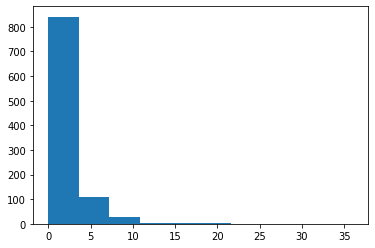

In [27]:
lessons_completed = list(total_lessons_completed.values())
describe_data(lessons_completed)

Mean: 2.8673366834170855
Standard Deviation: 2.2551980029196814
Minimum: 0
Maximum: 7


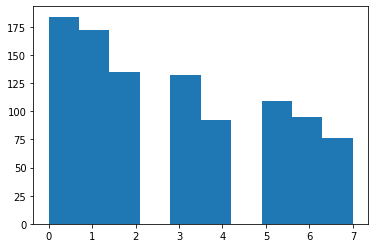

In [28]:
num_of_days_visited = sum_grouped_items(engagement_by_account,'has_visited')
describe_data(list(num_of_days_visited.values()))

In [29]:
subway_project_lesson_keys = ['746169184', '3176718735']

#passed_students = list()
passed_subway_project = set()

#passing_engagement = []

for submission in paid_udacity_submission:
    project = submission['lesson_key']
    rating = submission['assigned_rating']
    if project in subway_project_lesson_keys and (rating == 'PASSED' or rating == 'DISTINCTION'):
        passed_subway_project.add(submission['account_key'])
        
print(len(passed_subway_project))


647


In [30]:
passing_engagement = []
non_passing_engagement = []
for engagement in paid_engagement_in_first_week:
    if engagement['account_key'] in passed_subway_project:
        passing_engagement.append(engagement)
    else:
        non_passing_engagement.append(engagement)
        
len(passing_engagement)
len(non_passing_engagement)

2392

In [31]:
#for engagement_record in passing_engagement:
#    print(engagement_record)
print(passing_engagement[10])

OrderedDict([('account_key', '1'), ('utc_date', datetime.datetime(2015, 5, 9, 0, 0)), ('num_courses_visited', 0), ('total_minutes_visited', 0.0), ('lessons_completed', 0), ('projects_completed', 0), ('has_visited', 0)])


Passing engagement total mins:
Mean: 394.58604648350865
Standard Deviation: 448.4995193265521
Minimum: 0.0
Maximum: 3564.7332644989997


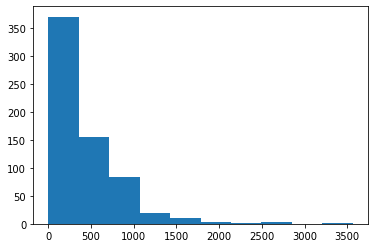

In [32]:
#comparison between passing engagement and non-passing engagement

passing_engagement_group = group_data(passing_engagement,'account_key')
total_mins_for_passed_students = sum_grouped_items(passing_engagement_group,'total_minutes_visited')
print('Passing engagement total mins:')
describe_data(list(total_mins_for_passed_students.values()))

Non passing engagement total mins:
Mean: 143.32647426675584
Standard Deviation: 269.5386190114951
Minimum: 0.0
Maximum: 1768.5227493319999


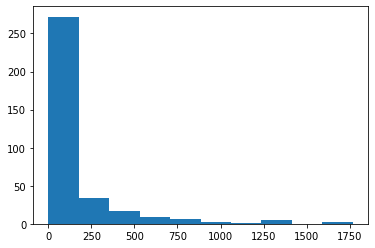

In [33]:
non_passing_engagement_group = group_data(non_passing_engagement,'account_key')
total_mins_for_non_passed_students = sum_grouped_items(non_passing_engagement_group,'total_minutes_visited')
print('Non passing engagement total mins:')
describe_data(list(total_mins_for_non_passed_students.values()))

Passing engagement lessons:


(array([384., 132.,  65.,  32.,   8.,  15.,   2.,   2.,   2.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ,
        19.8, 21.6, 23.4, 25.2, 27. , 28.8, 30.6, 32.4, 34.2, 36. ]),
 <a list of 20 Patch objects>)

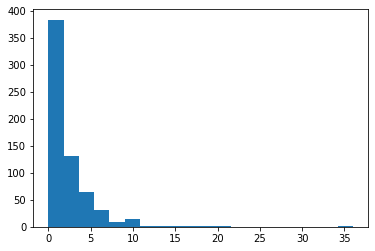

In [34]:
total_lessons_completed_by_passed_students = sum_grouped_items(passing_engagement_group,'lessons_completed')
print('Passing engagement lessons:')

plt.hist(list(total_lessons_completed_by_passed_students.values()), bins = 20)
#describe_data(list(total_lessons_completed_by_passed_students.values()))

Passing engagement days visited:


Text(0.5, 0, 'Number of days')

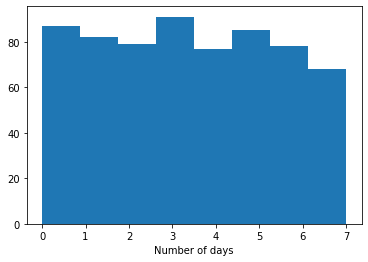

In [38]:

import seaborn as sns

total_days_visited_by_passed_students = sum_grouped_items(passing_engagement_group,'has_visited')
print('Passing engagement days visited:')

plt.hist(list(total_days_visited_by_passed_students.values()),bins =8)
plt.xlabel('Number of days')

Non passing engagement lessons:
Mean: 0.8620689655172413
Standard Deviation: 2.5491599418312028
Minimum: 0
Maximum: 27


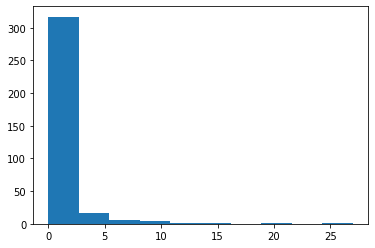

In [36]:
non_passing_engagement_group = group_data(non_passing_engagement,'account_key')
total_lessons_completed_by_non_passed_students = sum_grouped_items(non_passing_engagement_group,'lessons_completed')
print('Non passing engagement lessons:')
describe_data(list(total_lessons_completed_by_non_passed_students.values()))

Non passing engagement days visited:
Mean: 1.9051724137931034
Standard Deviation: 1.9057314413619046
Minimum: 0
Maximum: 7


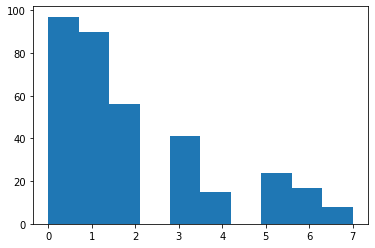

In [37]:
non_passing_engagement_group = group_data(non_passing_engagement,'account_key')
total_days_visited_by_non_passed_students = sum_grouped_items(non_passing_engagement_group,'has_visited')
print('Non passing engagement days visited:')
describe_data(list(total_days_visited_by_non_passed_students.values()))